In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def get_dataset():
    clear = open('clear.csv', 'r')
    clear_rows = clear.readlines()
    clear.close()
    
    smog = open('smog.csv', 'r')
    smog_rows = smog.readlines()
    smog.close()
    
    
    examples = len(clear_rows)
#     print(examples)
#     clear_datasets = np.zeros([examples, 300001])
    clear_datasets = []
    smog_datasets = []
    for i in range(examples):
        single_row = clear_rows[i]
        single_row = single_row.split(',')

        single_row = np.asarray(single_row, dtype = np.int32)
        label = np.array(1)
        clear_datasets.append(np.hstack([label, single_row]))
    
    for i in range(examples):
        single_row = smog_rows[i]
        single_row = single_row.split(',')
        single_row = np.asarray(single_row, dtype = np.int32)
        label = np.array(0)
        smog_datasets.append(np.hstack([label, single_row]))
        
    return clear_datasets + smog_datasets

In [3]:
datasets = get_dataset()

In [4]:
print(len(datasets))

9148


In [6]:
example = np.array(datasets)
np.random.shuffle(example)
examples = len(example)
# print(examples)
labels = np.array([example[i][0] for i in range(examples)])
images = np.array([example[i][1:].reshape(100, 100, 3) / 255 for i in range(examples)])



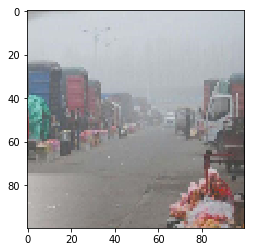

In [7]:
# example = example[6000]
# print(example)
# example = example[1:].reshape(100, 100, 3)
# # example = example.reshape(100, 100, 3)
# # print(example)
plt.imshow(images[501])
plt.show()

In [8]:
# import pickle


# outfile = open('datasets.pkf', 'wb')
# pickle.dump(example, outfile)
# outfile.close()

In [9]:
print(labels.shape, images.shape)

(9148,) (9148, 100, 100, 3)


In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3) 
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)


In [11]:
# inception 
from keras.layers import Input
from keras.models import Model

input_img = Input(shape = (100, 100, 3))

tower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(tower_1)
tower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)
tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

output = Flatten()(output)
# output = Dropout(0.5)(Dense(960000, activation = 'relu')(output))
out    = Dense(2, activation='softmax')(output)

model = Model(inputs = input_img, outputs = out)
print (model.summary())



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 100, 100, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 100, 100, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
#model used for DCR
model = Sequential()
model.add(Conv2D(32, (5, 5), activation = 'relu', input_shape = (100, 100, 3), data_format = 'channels_last'))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 32)        2432      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 92, 92, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)        25632     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
__________

In [13]:
#Compile the model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


In [14]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split = 0.1)

Train on 5762 samples, validate on 641 samples
Epoch 1/10
5762/5762 [==============================] - 520s 90ms/step - loss: 0.4334 - acc: 0.7990 - val_loss: 0.3385 - val_acc: 0.8705
Epoch 2/10
5762/5762 [==============================] - 458s 79ms/step - loss: 0.3314 - acc: 0.8638 - val_loss: 0.2443 - val_acc: 0.9017
Epoch 3/10
5762/5762 [==============================] - 450s 78ms/step - loss: 0.2980 - acc: 0.8808 - val_loss: 0.2295 - val_acc: 0.9189
Epoch 4/10
5762/5762 [==============================] - 448s 78ms/step - loss: 0.2804 - acc: 0.8891 - val_loss: 0.2761 - val_acc: 0.8939
Epoch 5/10
5762/5762 [==============================] - 453s 79ms/step - loss: 0.2659 - acc: 0.8933 - val_loss: 0.2245 - val_acc: 0.9173
Epoch 6/10
5762/5762 [==============================] - 452s 78ms/step - loss: 0.2678 - acc: 0.8947 - val_loss: 0.2276 - val_acc: 0.9033
Epoch 7/10
5762/5762 [==============================] - 465s 81ms/step - loss: 0.2652 - acc: 0.8955 - val_loss: 0.3073 - val_acc: 0

In [17]:
score = model.evaluate(x_test, y_test, batch_size=32, verbose = 1)
print("Loss: ", score[0], " Accuracy: ", score[1])

2745/2745 [==============================] - 82s 30ms/step
Loss:  0.3193966495209053  Accuracy:  0.869945354952404


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


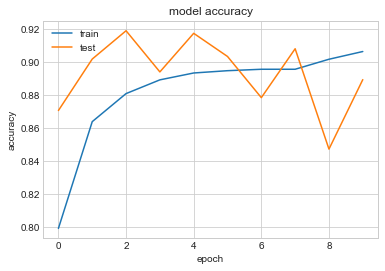

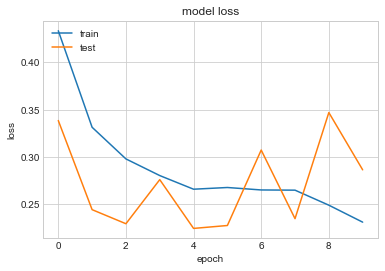

In [20]:
plt.style.use('seaborn-whitegrid')
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Try 1:
* I have image of size (100, 100, 3) i.e. RGB image inside the file clear.csv and smog.csv. There are 4574 examples for each.</br>
* I merged both files into single list instead of numpy array. Because while i was creating numpy array of size that large, memory error was occurring.
* After merging them, i created a numpy array of size (9841, 30000) then i shuffled all the images.
* The each row contains the image and corresponding label for class. i.e the row from clear file have label 1 and it is stored on first column.
* Next i made a array for both label and images. 
* Next i splitted 30% of training data for test.
* Next i created a CNN model using Keras.
* I used inception and SGD with categorical Cross entropy.
* But the fact is, the loss never decreased below 7 and accuracy never increased above 60% for train/validation.
* Plus the training time was very high for Inception. Single epoch was taking 30+min.
* I tried simple CNN that i used to train DCR(Devanagari Character Recognition) problem. It had 99.32% accuracy on trainset.
* But that model also took long and problem was same.
<hr>
<hr>


## Try 2:
* I found the solution to the loss and accuracy in <b>Try1</b>. 
* I never normalized the data before training. SO the problem of accuracy occured. 
* In this try, i used CNN from DCR, used Adam, CCE, 0.01 etc and in first epoch validation accuracy is 84.44%.
* I am going to train it on VGG and Inception both later tomorrow.


In [19]:
#save a model

from keras.models import model_from_json
from keras.models import load_model

print(keras.__version__)

model_json = model.to_json()

with open("model1.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model1.h5")

2.1.3


0 0


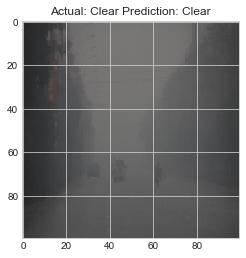

1 1


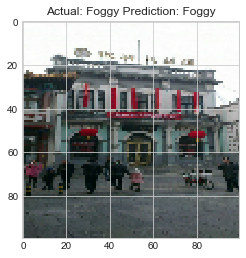

0 0


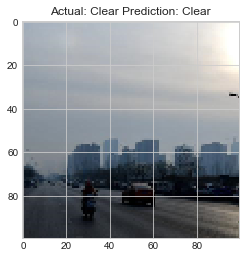

0 0


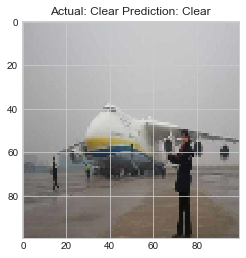

1 1


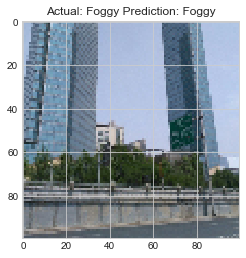

In [38]:
#check some examples

for i in range(5):
    img = x_test[i].reshape(1, 100, 100, 3)
    lbl = np.argmax(y_test[i])
    prediction = model.predict(img)
#     print(prediction)
    prediction = np.argmax(prediction)
    print(prediction, lbl)
    classes = ["Clear", "Foggy"]
    title = f"Actual: {classes[lbl]} Prediction: {classes[prediction]}"
    plt.imshow(img.reshape(100, 100, 3))
    plt.title(title)
    plt.show()